# ROXSI 2022 SSA Nortek Signature 1000
Visualize Sig1000 data QC and statistical parameters from ROXSI 2022 Asilomar Small-Scale Array measurements.

In [11]:
# Imports
import os
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
from pyproj import Proj
import cmocean
import ipympl
import matplotlib.pyplot as plt
# Interactive plots
%matplotlib widget 


In [2]:
# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
data_root = os.path.join(rootdir, 'Signatures', 'Level1')
bathydir = os.path.join(rootdir, 'Bathy')

# Read API key from environment variable
api_key = os.environ["OPENAI_API_KEY"]

# Read large-scale array mooring locations table
fn_lsa = os.path.join(rootdir, 'ROXSI2022_LSA_mooring_locations.csv')
df_lsa = pd.read_csv(fn_lsa).set_index('Mooring')

# Sig100 serial number to visualize
# Choices: ['103088', '103094', '103110', '103063', '103206']
ser = 103094
veldir = os.path.join(data_root, '{}'.format(ser)) # Velocity netcdf directory
specdir = os.path.join(data_root, '{}'.format(ser), 'Spectra') # Spectra netcdf directory

# Visualize one date or all dates?
# dates = ['2022-07-01']
dates = 'all'

## Read and plot bathymetry
First plot closeups of SSA bathymetry with Signature moorings marked with triangles.

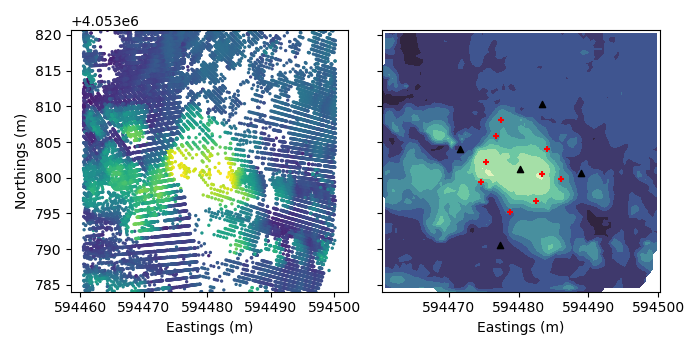

In [3]:
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsb = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

# Initialize figure and plot
plt.close()
fig, axes = plt.subplots(figsize=(7,3.5), ncols=2, constrained_layout=True,
                         sharey=True)
axes[0].scatter(dsb.x_pts, dsb.y_pts, c=dsb.z_pts, s=2)
axes[0].set_xlabel('Eastings (m)')
axes[0].set_ylabel('Northings (m)')
axes[1].contourf(dsb.eastings, dsb.northings, dsb.z_utm, vmin=-8.0, vmax=-3.5,
                 cmap=cmocean.cm.deep_r)
# Mooring locations
s = 20 # markersize
axes[1].scatter(dsb.C1_utm[0].item(), dsb.C1_utm[1].item(), marker='^', color='k', s=s)
axes[1].scatter(dsb.C2_utm[0].item(), dsb.C2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C3_utm[0].item(), dsb.C3_utm[1].item(), marker='^', color='k', s=s)
axes[1].scatter(dsb.C4_utm[0].item(), dsb.C4_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C5_utm[0].item(), dsb.C5_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C6_utm[0].item(), dsb.C6_utm[1].item(), marker='^', color='k', s=s)
axes[1].scatter(dsb.L1_utm[0].item(), dsb.L1_utm[1].item(), marker='^', color='k', s=s)
axes[1].scatter(dsb.L2_utm[0].item(), dsb.L2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.L4_utm[0].item(), dsb.L4_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.L5_utm[0].item(), dsb.L5_utm[1].item(), marker='^', color='k', s=s)
axes[1].scatter(dsb.C2L2_utm[0].item(), dsb.C2L2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C2L4_utm[0].item(), dsb.C2L4_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C4L2_utm[0].item(), dsb.C4L2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C4L4_utm[0].item(), dsb.C4L4_utm[1].item(), marker='+', color='r', s=s)
axes[1].set_xlabel('Eastings (m)')

plt.tight_layout()
plt.show()


## Read Level 1 velocity data
If visualizing all dates, concatenate daily netcdf files into one xr.Dataset.

In [12]:
# List velocity netcdf files for specified serial number
fns_nc_vel = sorted(glob.glob(os.path.join(veldir, '*Vel_*.nc')))
dsl = [] # Empty list for concatenating velocity datasets
# Iterate over and read files, and append to list for concatenating
for fn in tqdm(fns_nc_vel):
    dsi = xr.decode_cf(xr.open_dataset(fn, decode_coords='all'))
    # Take 20+min averages
    dsi = dsi.resample(time='20T').mean()
    dsl.append(dsi) # Append
# Concatenate datasets into one
ds = xr.concat(dsl, dim='time')

# Read one full dataset
dsi = xr.decode_cf(xr.open_dataset(fns_nc_vel[0], decode_coords='all'))

  0%|          | 0/26 [00:00<?, ?it/s]

## Plot time series of mean horizontal vs vertical velocity

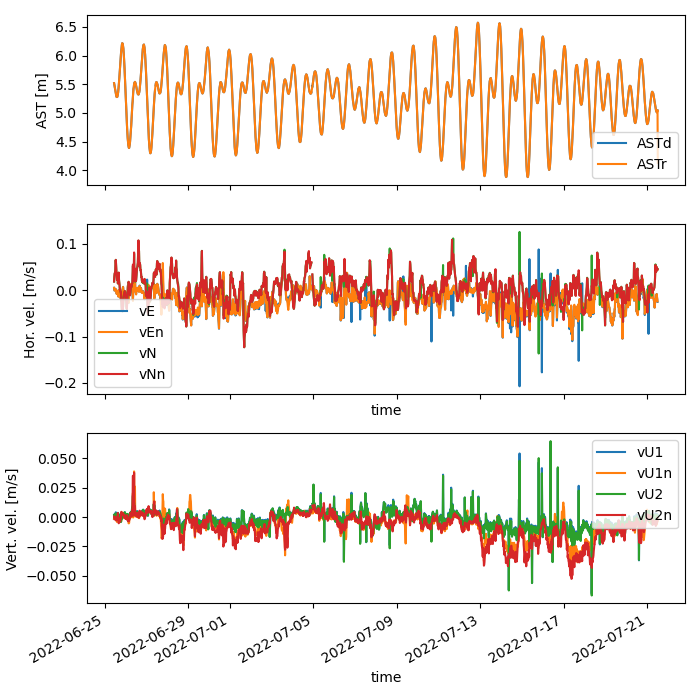

In [7]:
fig, axes = plt.subplots(figsize=(7,7), nrows=3, sharex=True, constrained_layout=True)
# Plot mean AST signal on top
ds.ASTd.plot(ax=axes[0], label='ASTd')
ds.ASTr.plot(ax=axes[0], label='ASTr')
axes[0].set_ylabel('AST [m]')
axes[0].set_xlabel('')
# Plot vertically-avg'd mean horizontal velocities in middle
ds.vEhpr.mean(dim='range', skipna=True).plot(ax=axes[1], label='vE')
ds.vE.where(ds.vEhpr.notnull()).mean(dim='range', skipna=True).plot(ax=axes[1], label='vEn')
ds.vNhpr.mean(dim='range', skipna=True).plot(ax=axes[1], label='vN')
ds.vN.where(ds.vNhpr.notnull()).mean(dim='range', skipna=True).plot(ax=axes[1], label='vNn')
axes[1].set_ylabel('Hor. vel. [m/s]')
axes[0].set_xlabel('')
# Plot vertically-avg'd mean vertical velocities on bottom
ds.vU1hpr.mean(dim='range', skipna=True).plot(ax=axes[2], label='vU1')
ds.vU1.where(ds.vU1hpr.notnull()).mean(dim='range', skipna=True).plot(ax=axes[2], label='vU1n')
ds.vU2hpr.mean(dim='range', skipna=True).plot(ax=axes[2], label='vU2')
ds.vU2.where(ds.vU2hpr.notnull()).mean(dim='range', skipna=True).plot(ax=axes[2], label='vU2n')
axes[2].set_ylabel('Vert. vel. [m/s]')
axes[0].set_xlabel('')

axes[0].legend()
axes[1].legend()
axes[2].legend()

plt.tight_layout()
plt.show()

In [36]:
plt.clf()

## Nortek vs. calculated mean velocities
Compare velocities estimated by Nortek software (vE, vN, vU1, vU2) vs. despiked velocities computed from time series of heading, pitch and roll (vEhpr, vNhpr, vU1hpr, vU2hpr).

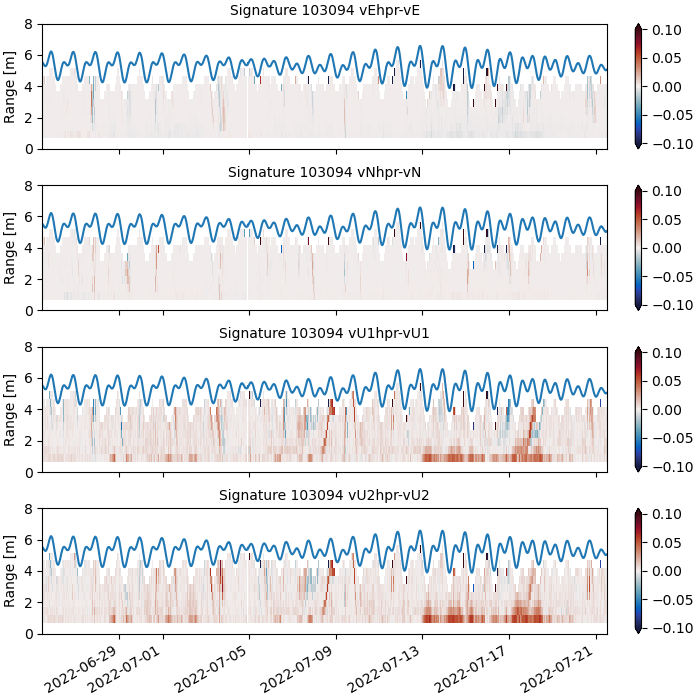

In [19]:
# Initialize figure
fig, axes = plt.subplots(figsize=(7,7), nrows=4, sharex=True, sharey=True,
                         constrained_layout=True)
vmin = -0.1
vmax = 0.1
fontsize = 10
# diff of vE on top
(ds.vEhpr - ds.vE).plot.pcolormesh(ax=axes[0], x='time', y='range', vmin=vmin, vmax=vmax,
                                   cmap=cmocean.cm.balance, label='vEhpr-vE')
ds.ASTd.plot(ax=axes[0], label='ASTd') # Include AST surface signal
axes[0].set_title('Signature {} vEhpr-vE'.format(ser), fontsize=fontsize)
# diff of vN in middle
(ds.vNhpr - ds.vN).plot.pcolormesh(ax=axes[1], x='time', y='range', vmin=vmin, vmax=vmax,
                                   cmap=cmocean.cm.balance, label='vNhpr-vN')
ds.ASTd.plot(ax=axes[1], label='ASTd') # Include AST surface signal
axes[1].set_title('Signature {} vNhpr-vN'.format(ser), fontsize=fontsize)
# diff of vU1 in middle
(ds.vU1hpr - ds.vU1).plot.pcolormesh(ax=axes[2], x='time', y='range', vmin=vmin, vmax=vmax,
                                   cmap=cmocean.cm.balance, label='vU1hpr-vU1')
ds.ASTd.plot(ax=axes[2], label='ASTd') # Include AST surface signal
axes[2].set_title('Signature {} vU1hpr-vU1'.format(ser), fontsize=fontsize)
# diff of vU2 on bottom
(ds.vU2hpr - ds.vU2).plot.pcolormesh(ax=axes[3], x='time', y='range', vmin=vmin, vmax=vmax,
                                   cmap=cmocean.cm.balance, label='vU2hpr-vU2')
ds.ASTd.plot(ax=axes[3], label='ASTd') # Include AST surface signal
axes[3].set_title('Signature {} vU2hpr-vU2'.format(ser), fontsize=fontsize)

# Set axis labels and limits
for ax in axes:
    ax.set_ylim([0,8])
    ax.set_xlabel('')
    ax.set_ylabel('Range [m]')

plt.show()

In [25]:
ds.vE.where(ds.vEhpr.notnull())
# plt.clf()

<xarray.DataArray 'vE' (time: 1877, range: 28)>
array([[ 0.00260781, -0.00280789, -0.00104436, ...,         nan,
                nan,         nan],
       [ 0.00635711, -0.00250725, -0.00564108, ...,         nan,
                nan,         nan],
       [ 0.00937191,  0.00445839, -0.00195245, ...,         nan,
                nan,         nan],
       ...,
       [ 0.00421998, -0.02486296, -0.03751427, ...,         nan,
                nan,         nan],
       [-0.01324865, -0.03363451, -0.04491946, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * range    (range) float64 0.9188 1.419 1.919 2.419 ... 13.42 13.92 14.42
  * time     (time) datetime64[ns] 2022-06-25T11:00:00 ... 2022-07-21T12:20:00
Attributes:
    standard_name:  eastward_sea_water_velocity
    long_name:      Eastward velocity from Nortek software
    units:          m/s

TypeError: No numeric data to plot.

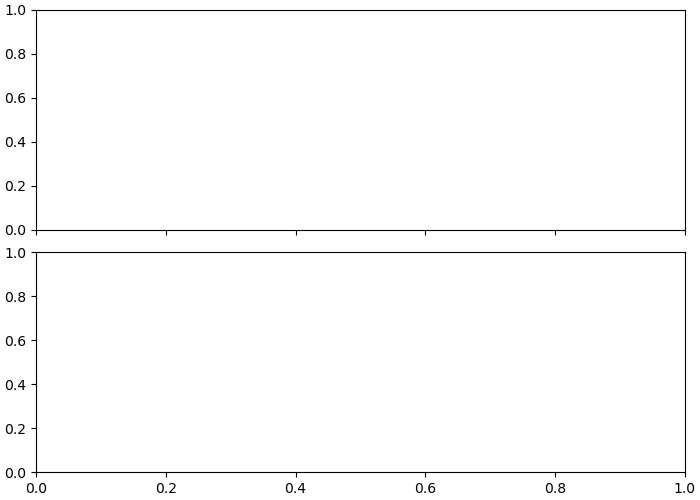

In [41]:
# Read 2022-07-07 dataset and plot
dsi = xr.decode_cf(xr.open_dataset(fns_nc_vel[0], decode_coords='all'))

# Plot specified time period
t0 = pd.Timestamp('2022-06-25 18:20:00')
t1 = pd.Timestamp('2022-06-25 18:40:00')
fig, axes = plt.subplots(figsize=(7,5), nrows=2, sharex=True, sharey=True, 
                         constrained_layout=True)
# dsi.sel(time=slice(t0, t1)).vEhpr.plot.pcolormesh(x='time', y='range', ax=axes[0], 
#                                                   label='vEhpr')
dsi.sel(time=slice(t0, t1)).vE.where(dsi.range<dsi.ASTd).plot.pcolormesh(x='time', y='range', 
    ax=axes[0], label='vEhpr')

dsi.sel(time=slice(t0, t1)).ASTd.plot(ax=axes[0])
dsi.sel(time=slice(t0, t1)).z_hyd.plot(ax=axes[0])
dsi.sel(time=slice(t0, t1)).vNhpr.plot.pcolormesh(x='time', y='range', ax=axes[1], 
                                                  label='vNhpr')
dsi.sel(time=slice(t0, t1)).ASTd.plot(ax=axes[1])
dsi.sel(time=slice(t0, t1)).z_hyd.plot(ax=axes[1])
for ax in axes:
    ax.set_ylim([0,7])
    ax.set_xlabel(None)

plt.show()




In [39]:
dsi.vE.where(dsi.range<dsi.ASTd)

<xarray.DataArray 'vE' (time: 345600, range: 28)>
array([[-0.27483165, -0.35767496, -0.27084047, ...,         nan,
                nan,         nan],
       [-0.7248882 , -0.46230072, -0.3188822 , ...,         nan,
                nan,         nan],
       [-0.33953932, -0.3966074 , -0.4136049 , ...,         nan,
                nan,         nan],
       ...,
       [ 0.00658943,  0.14322369,  0.10030437, ...,         nan,
                nan,         nan],
       [ 0.14108136,  0.20839863,  0.06096768, ...,         nan,
                nan,         nan],
       [ 0.18343127, -0.1687066 , -0.1167099 , ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-07-07T00:00:00.126110 ... 2022-07-07T...
  * range    (range) float64 0.9188 1.419 1.919 2.419 ... 13.42 13.92 14.42
Attributes:
    standard_name:  eastward_sea_water_velocity
    long_name:      Eastward velocity from Nortek software
    units:          m/s